In [17]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from sklearn.datasets import make_moons

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Raw Data

In [18]:
x, y = make_moons(noise=0.3, random_state=0)

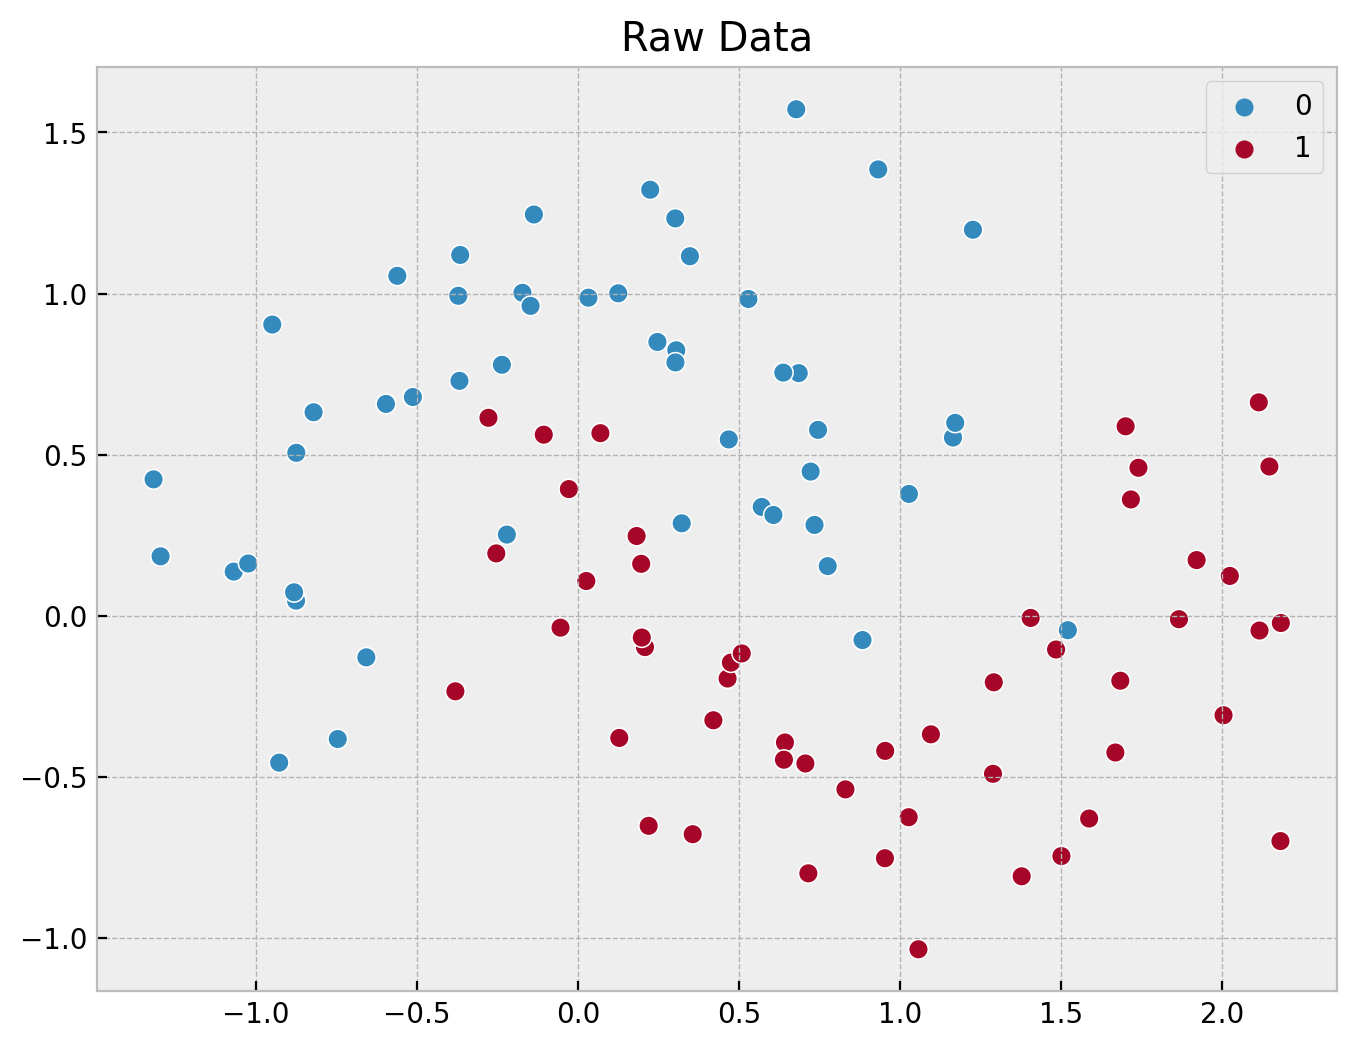

In [116]:
fig, ax = plt.subplots()
sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, hue=y, ax=ax)
ax.set(title="Raw Data");

## Linear Model

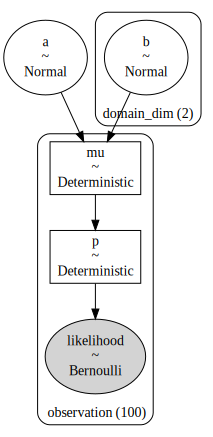

In [28]:
coords = {
    "observation": np.arange(x.shape[0]),
    "domain_dim": np.arange(x.shape[1]),
}

with pm.Model(coords=coords) as linear_model:
    # priors
    a = pm.Normal(name="a", mu=0, sigma=2)
    b = pm.Normal(name="b", mu=0, sigma=2, dims="domain_dim")
    # model parametrization
    mu = pm.Deterministic(name="mu", var=pm.math.dot(x, b) + a, dims="observation")
    p = pm.Deterministic(name="p", var=pm.math.sigmoid(mu), dims="observation")
    # likelihood
    likelihood = pm.Bernoulli(name="likelihood", p=p, dims="observation", observed=y)

pm.model_to_graphviz(model=linear_model)

In [33]:
with linear_model:
    linear_idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    linear_posterior_predictive = pm.sample_posterior_predictive(trace=linear_idata)

Compiling...
Compilation time =  0:00:01.415157
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:03.291434
Transforming variables...
Transformation time =  0:00:00.045951
Computing Log Likelihood...
Log Likelihood time =  0:00:00.236682


In [34]:
az.summary(data=linear_idata, var_names=["a", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.112,0.36,-0.536,0.829,0.003,0.003,11411.0,10295.0,1.0
b[0],1.403,0.37,0.712,2.099,0.004,0.003,10419.0,9750.0,1.0
b[1],-3.354,0.69,-4.717,-2.130,0.007,0.005,11412.0,10035.0,1.0


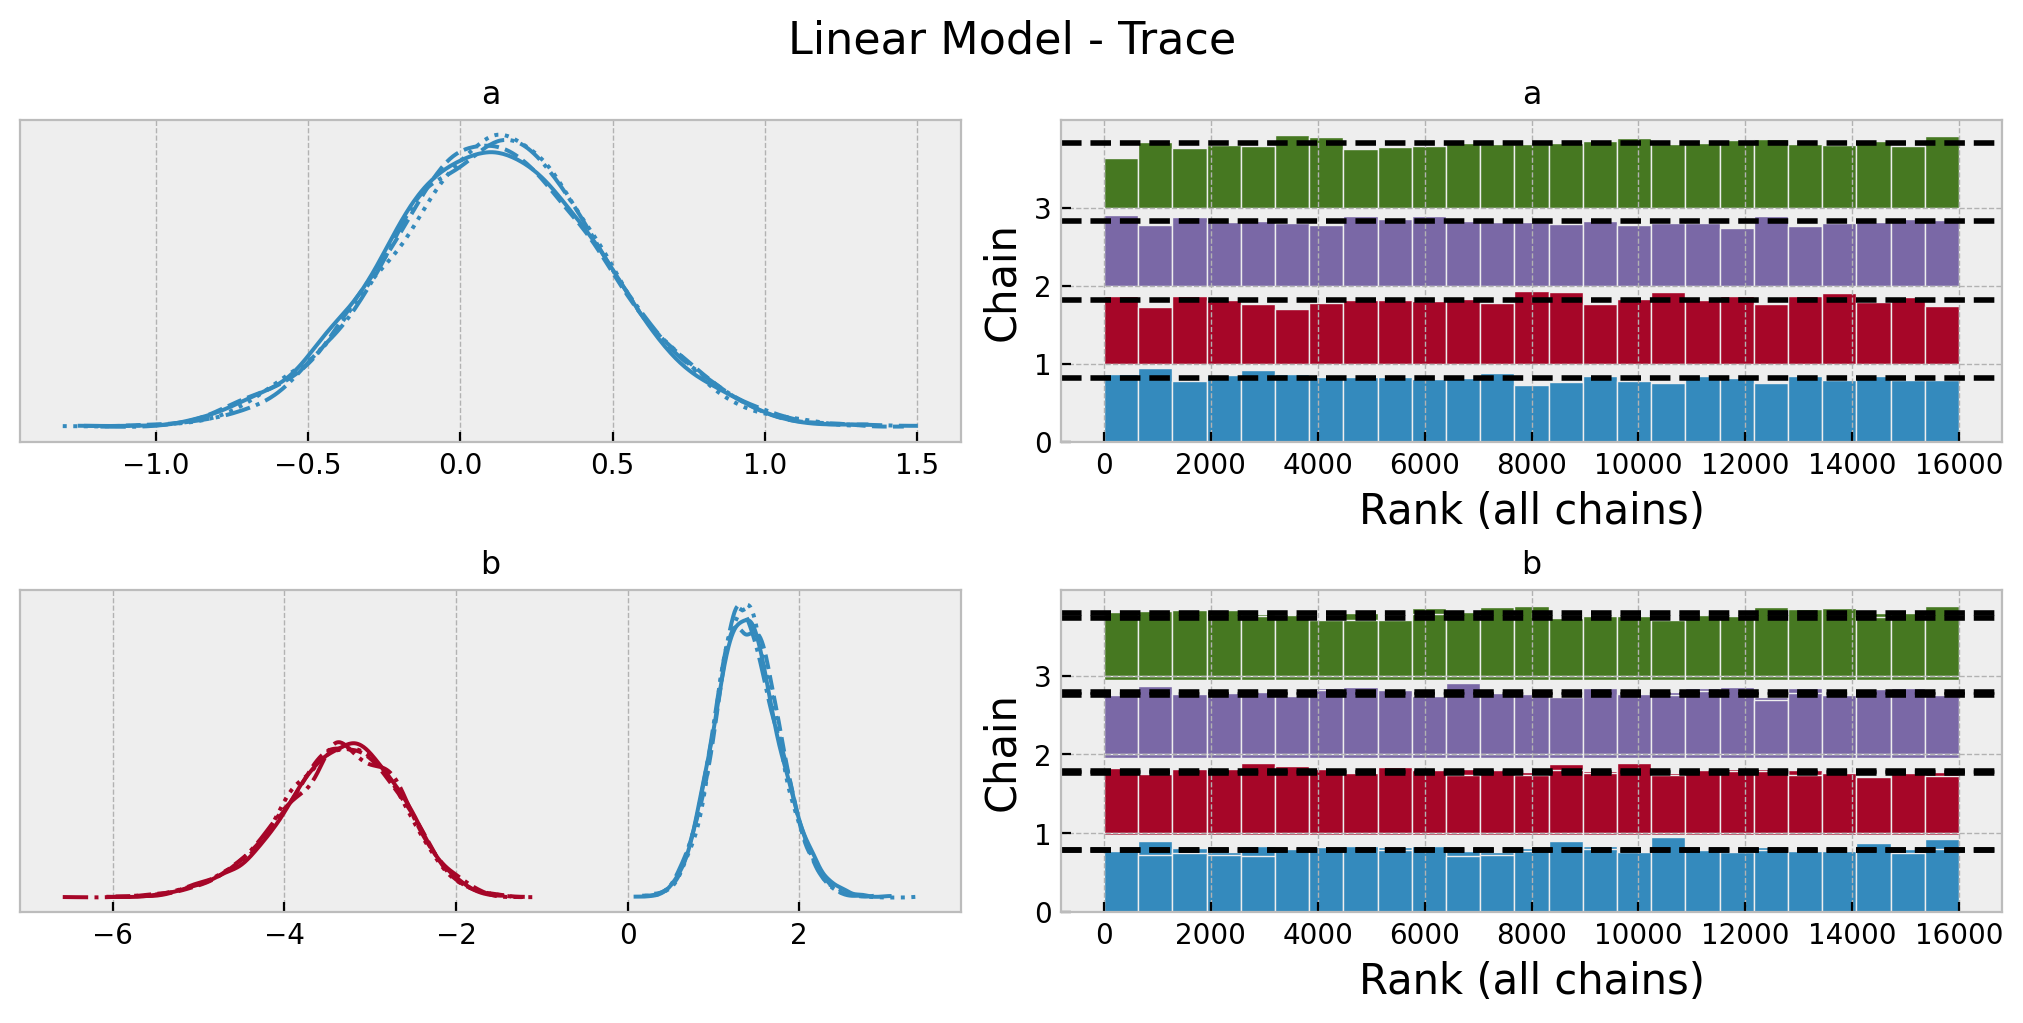

In [35]:
axes = az.plot_trace(
    data=linear_idata,
    var_names=["a", "b"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Model - Trace", fontsize=16);

[Text(0.5, 1.0, 'Linear Model - Posterior Predictive Mean')]

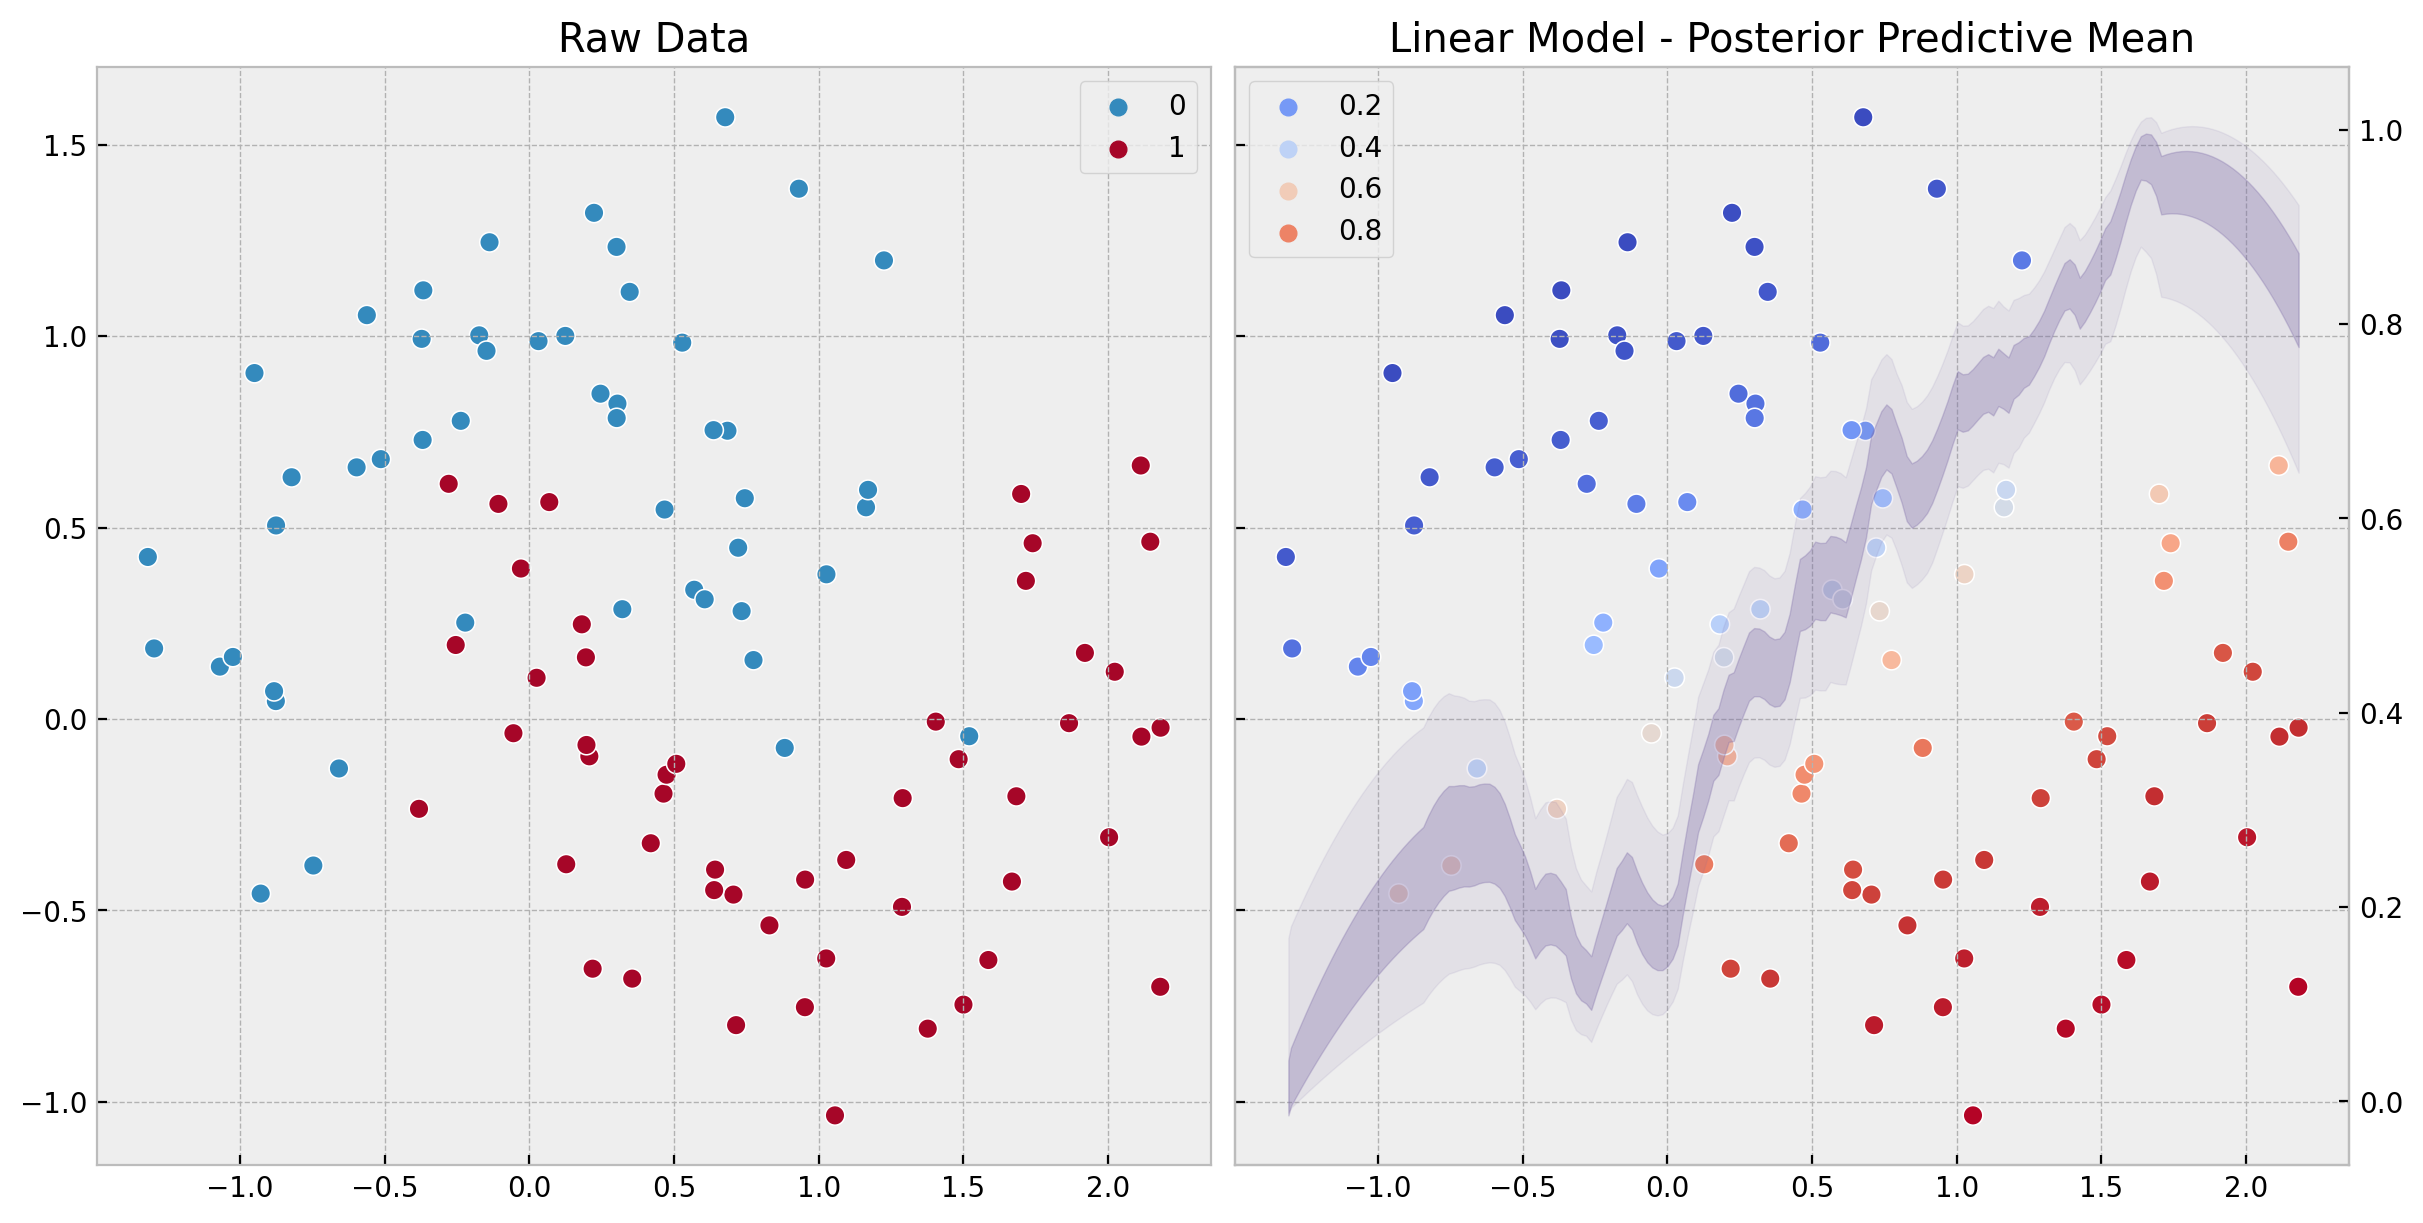

In [176]:
linear_posterior_predictive_mean = (
    linear_posterior_predictive.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True, layout="constrained"
)

sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, hue=y, ax=ax[0])
ax[0].set(title="Raw Data")

ax_1_twin = ax[1].twinx()
az.plot_hdi(
    x=x[:, 0],
    y=linear_idata.posterior["p"],
    color="C2",
    fill_kwargs={"alpha": 0.1},
    ax=ax_1_twin,
)
az.plot_hdi(
    x=x[:, 0],
    y=linear_idata.posterior["p"],
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.3},
    ax=ax_1_twin,
)
sns.scatterplot(
    x=x[:, 0],
    y=x[:, 1],
    s=50,
    hue=linear_posterior_predictive_mean,
    palette="coolwarm",
    ax=ax[1],
)
ax_1_twin.grid(None)
ax[1].legend(loc="upper left")
ax[1].set(title="Linear Model - Posterior Predictive Mean")


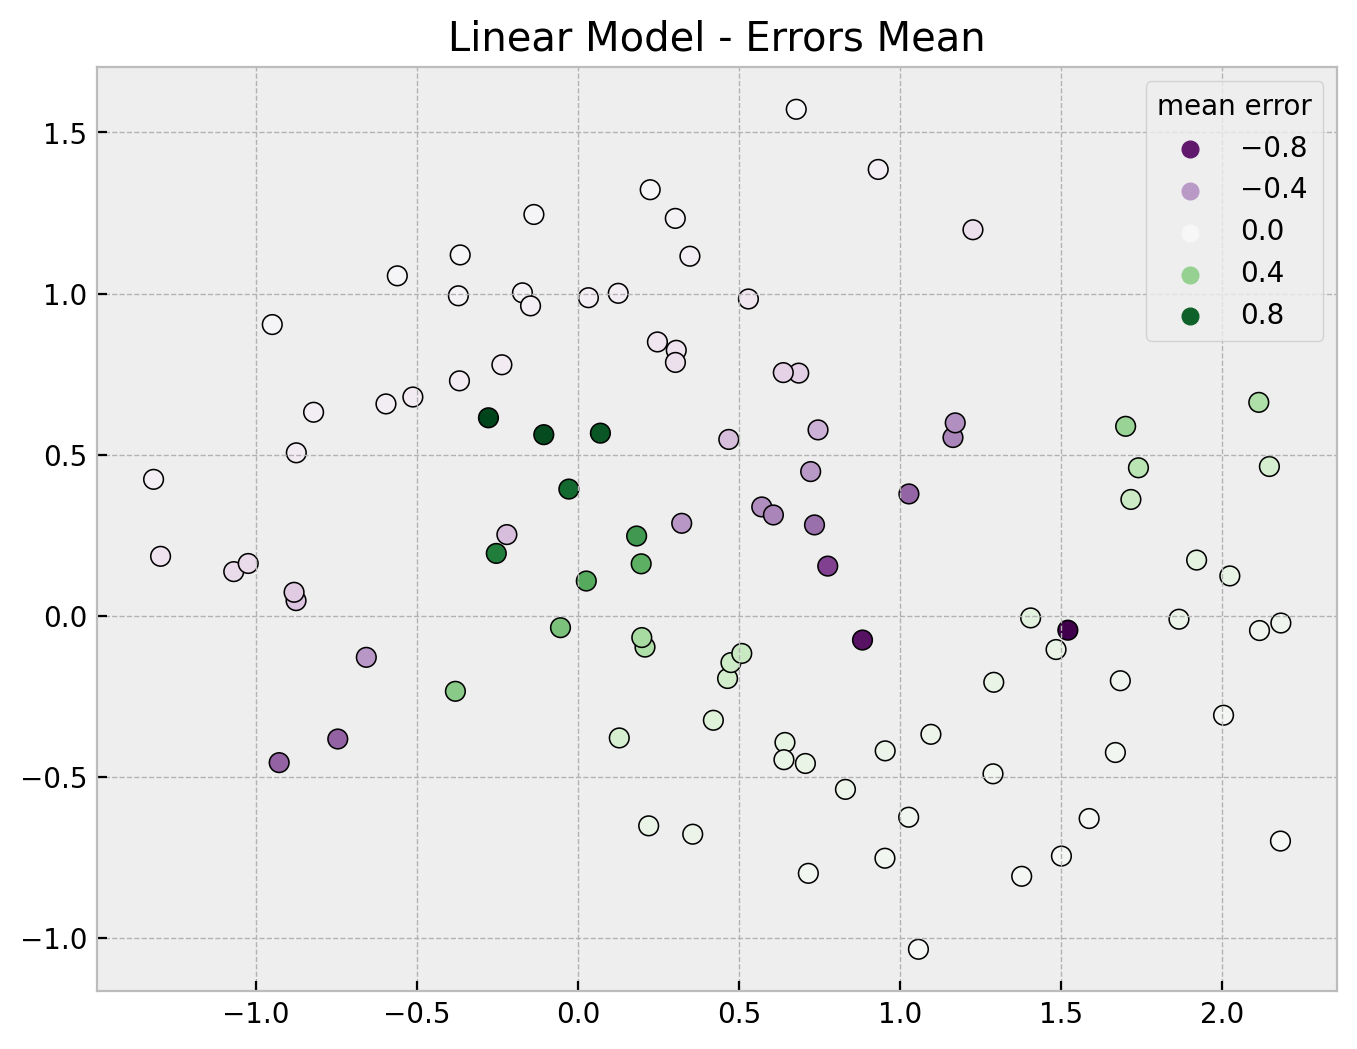

In [132]:
linear_errors_mean = (
    y[..., None] - linear_posterior_predictive.posterior_predictive["likelihood"].stack(sample=("chain", "draw"))
).mean(axis=1)

fig, ax = plt.subplots()
sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, edgecolor="black", hue=linear_errors_mean, palette="PRGn", ax=ax)
ax.legend(title="mean error")
ax.set(title="Linear Model - Errors Mean");

## Gaussian Process

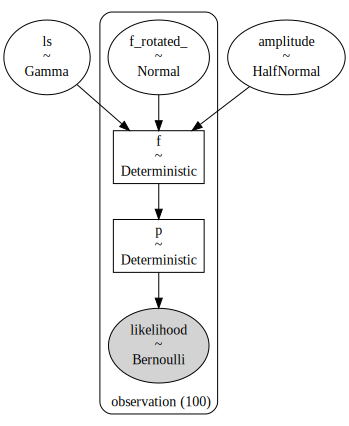

In [125]:
with pm.Model(coords=coords) as gp_model:

    ls = pm.Gamma(name="ls", alpha=2, beta=1)
    amplitude = pm.HalfNormal(name="amplitude", sigma=5)
    cov = amplitude ** 2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

    gp= pm.gp.Latent(cov_func=cov)
    f = gp.prior(name="f", X=x, dims="observation")
    p = pm.Deterministic(name="p", var=pm.math.sigmoid(f), dims="observation")
    # likelihood
    likelihood = pm.Bernoulli(name="likelihood", p=p, dims="observation", observed=y)

pm.model_to_graphviz(model=gp_model)

In [126]:
with gp_model:
    gp_idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    gp_posterior_predictive = pm.sample_posterior_predictive(trace=gp_idata)

Compiling...
Compilation time =  0:00:15.542954
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:04:26.275511
Transforming variables...
Transformation time =  0:00:46.592610
Computing Log Likelihood...
Log Likelihood time =  0:00:50.768971


In [129]:
az.summary(data=gp_idata, var_names=["ls", "amplitude"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls,0.746,0.150,0.476,1.031,0.001,0.001,9910.0,9361.0,1.0
amplitude,7.362,2.378,3.277,11.768,0.021,0.015,12266.0,12452.0,1.0


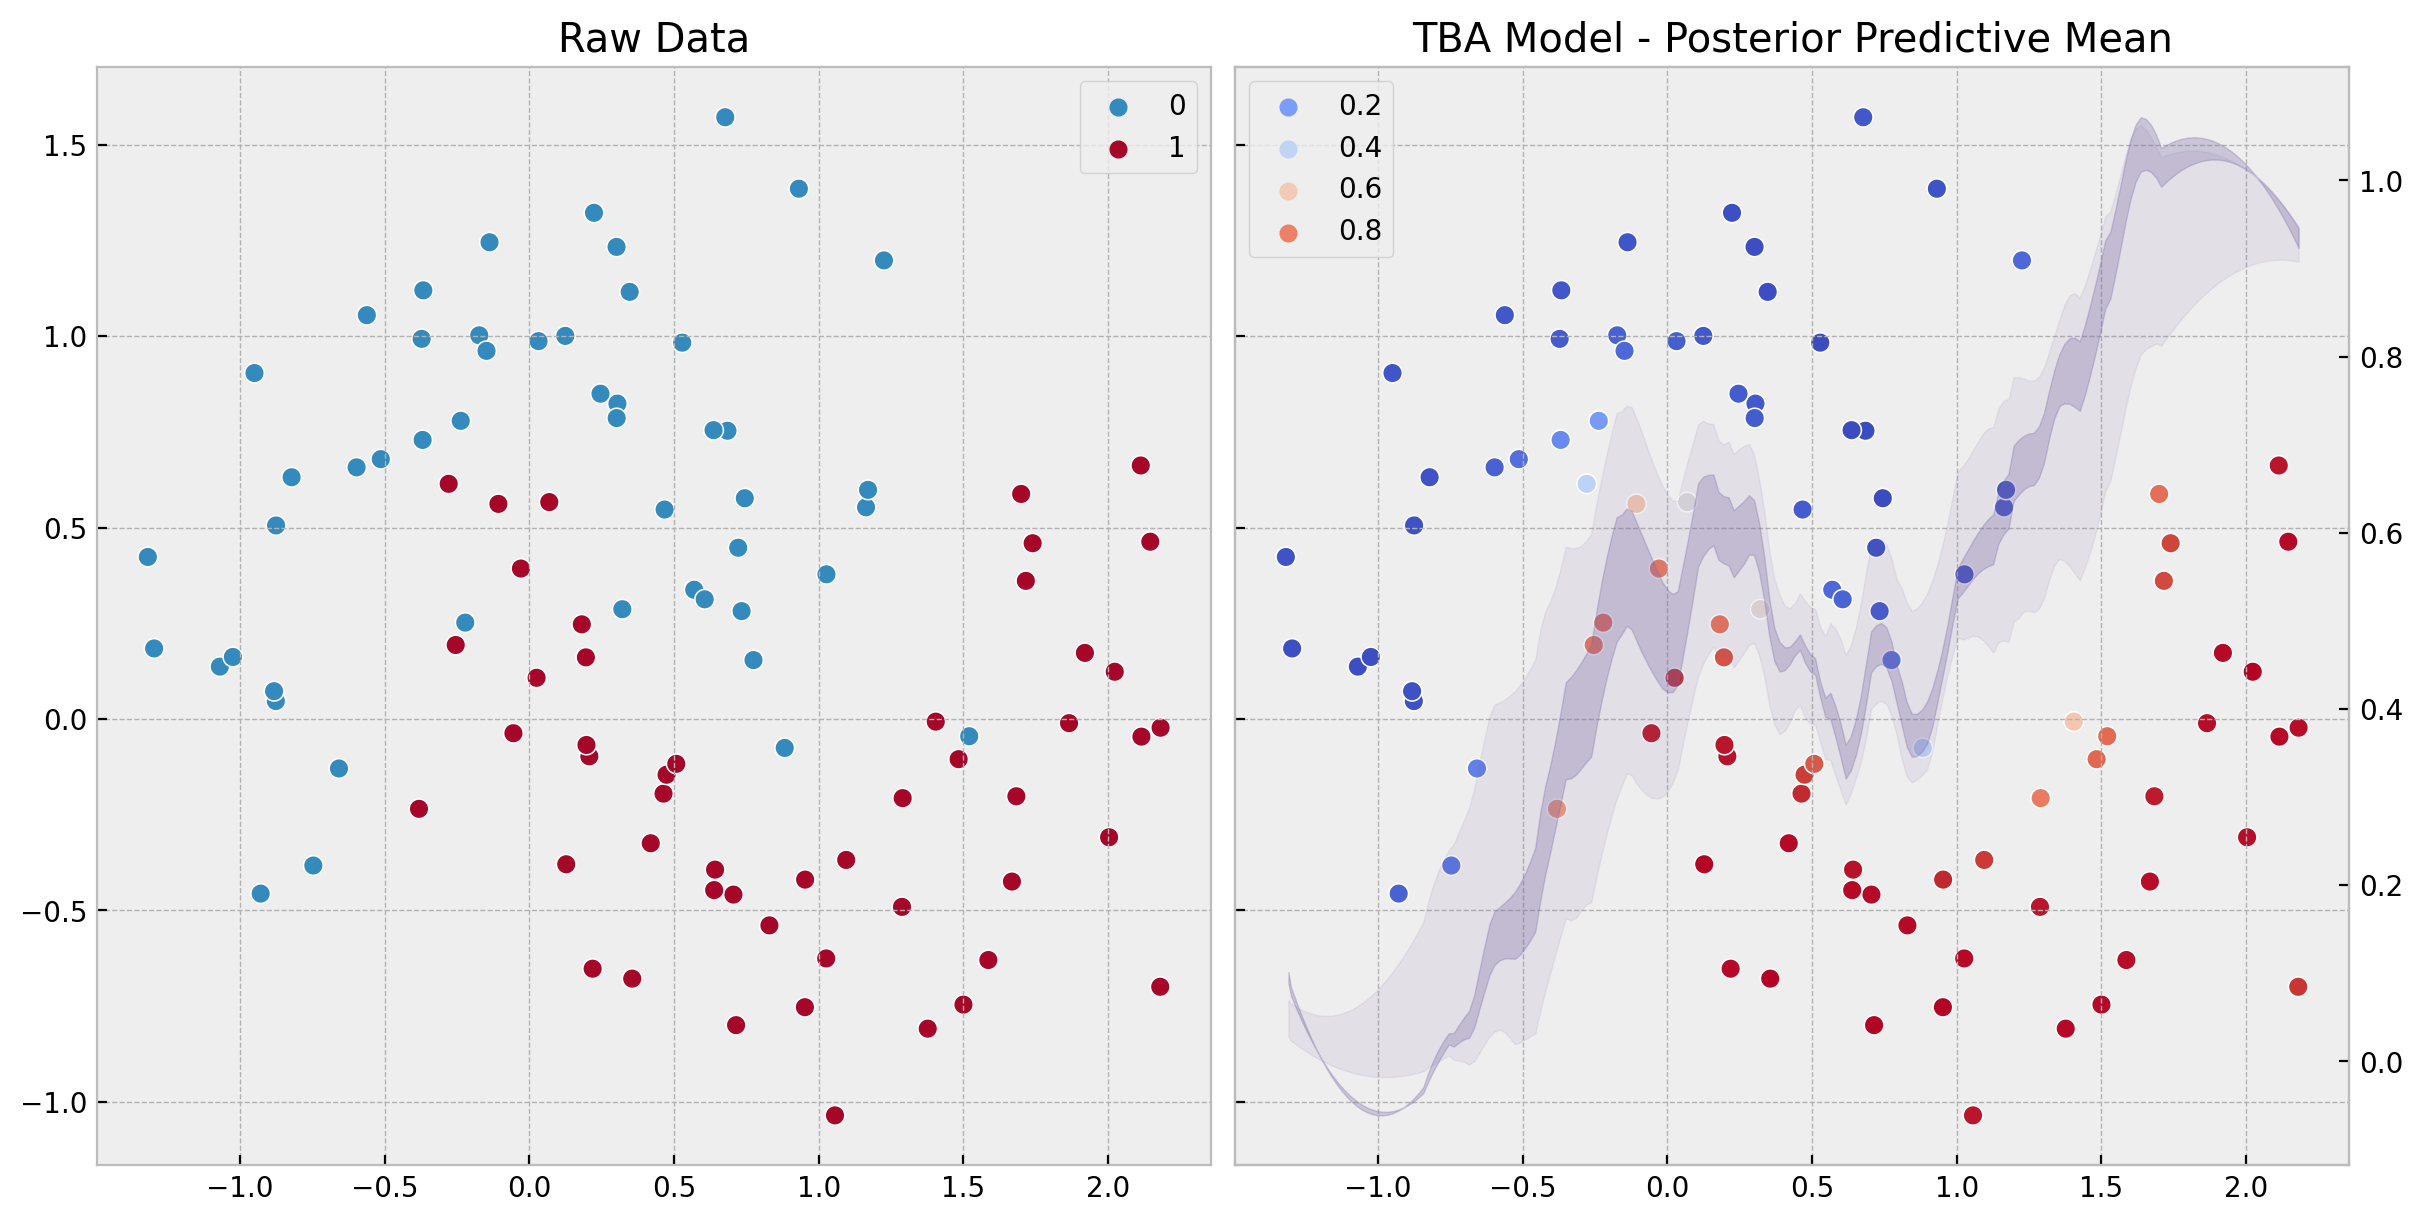

In [177]:
gp_posterior_predictive_mean = (
    gp_posterior_predictive.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True, layout="constrained"
)

sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, hue=y, ax=ax[0])
ax[0].set(title="Raw Data")

ax_1_twin = ax[1].twinx()
az.plot_hdi(
    x=x[:, 0],
    y=gp_idata.posterior["p"],
    color="C2",
    fill_kwargs={"alpha": 0.1},
    ax=ax_1_twin,
)
az.plot_hdi(
    x=x[:, 0],
    y=gp_idata.posterior["p"],
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.3},
    ax=ax_1_twin,
)
sns.scatterplot(
    x=x[:, 0],
    y=x[:, 1],
    s=50,
    hue=gp_posterior_predictive_mean,
    palette="coolwarm",
    ax=ax[1],
)
ax_1_twin.grid(None)
ax[1].legend(loc="upper left")
ax[1].set(title="TBA Model - Posterior Predictive Mean");

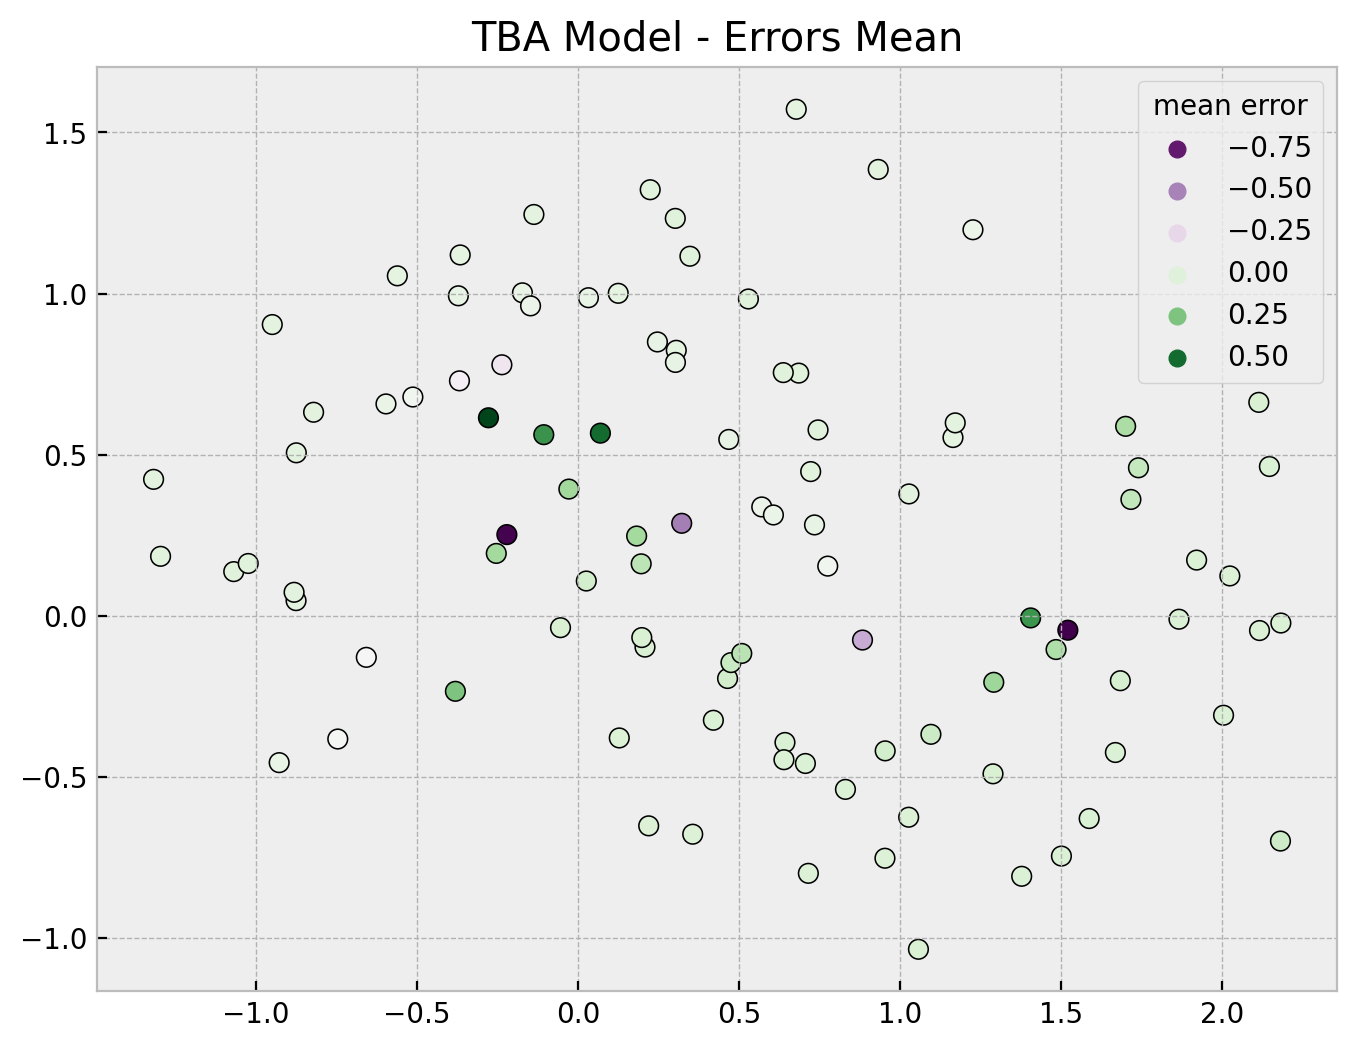

In [134]:
gp_errors_mean = (
    y[..., None] - gp_posterior_predictive.posterior_predictive["likelihood"].stack(sample=("chain", "draw"))
).mean(axis=1)

fig, ax = plt.subplots()
sns.scatterplot(x=x[:, 0], y=x[:, 1], s=50, edgecolor="black", hue=gp_errors_mean, palette="PRGn", ax=ax)
ax.legend(title="mean error")
ax.set(title="TBA Model - Errors Mean");